In [1]:
import os
import tensorflow as tf
import pandas as pd
from tensorflow.keras import Input, Model, layers
from tensorflow.keras.layers import Lambda, Conv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose, concatenate, Activation, Concatenate
from tensorflow.keras.metrics import IoU, BinaryIoU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K
import datetime
AUTOTUNE = tf.data.experimental.AUTOTUNE

2022-12-02 15:48:56.966461: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-02 15:48:57.138385: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-02 15:48:57.138408: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-02 15:48:57.974550: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

In [2]:
#Deviding data by batches

In [3]:
path_X = '/home/lewagon/code/Dponomareva/test/data/Images'

In [4]:
path_y = '/home/lewagon/code/Dponomareva/test/data/Target'

In [5]:
split_ratio = 0.8

In [6]:
def train_val_split (path_X, path_y, split_ratio):
    X_names = os.listdir(path_X)
    y_names = os.listdir(path_y)
    y_path = [f'{path_y}/{file}' for file in y_names]
    X_path = [f'{path_X}/{file}' for file in X_names]
    train_X, val_X = X_path[:int(len(X_path)*split_ratio)], X_path[int(len(X_path)*split_ratio):]
    train_y, val_y = y_path[:int(len(y_path)*split_ratio)], y_path[int(len(y_path)*split_ratio):]
    return train_X, val_X, train_y, val_y 

In [7]:
train_X, val_X, train_y, val_y = train_val_split (path_X, path_y, split_ratio)

In [8]:
def verify_matching_input_labels(X_names, y_names):
    for x, y in zip(X_names, y_names):
        if os.path.basename(x) != os.path.basename(y):
            raise ValueError(f"X and Y not matching: {x, y}")

In [9]:
verify_matching_input_labels(train_X, train_y)

In [10]:
verify_matching_input_labels(val_X, val_y)

In [11]:
def process_path(image_path, mask_path):
    image = tf.io.read_file(image_path)
    mask = tf.io.read_file(mask_path)
    image = tf.image.decode_png(image, channels = 3)
    mask = tf.image.decode_png(mask, channels = 1) / 255
    return image, mask

In [12]:
def batch_data(X_path, y_path, batch_size, train=True):
    ds = tf.data.Dataset.from_tensor_slices((X_path, y_path))
    #ds_train = ds_train.map(augment(process_path, num_parallel_calls=AUTOTUNE)
    ds = ds.shuffle(buffer_size = len(X_path), seed = 10).map(process_path)
    if train:
        ds = ds.map(augment)
    return ds.batch(batch_size).prefetch(AUTOTUNE)

In [13]:
def loss_sum(y_true, y_pred):
    def dice_loss(targets, inputs, smooth=1e-6):
    #flatten label and prediction tensors
        inputs = K.flatten(inputs)
        targets = K.flatten(targets)
    
        intersection = K.sum(targets * inputs)
        dice = (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
        return 1 - dice

    y_true = tf.cast(y_true, tf.float32)
    #y_pred = tf.cast(y_pred, tf.float32)
    o = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred) + dice_loss(y_true, y_pred)
    return tf.reduce_mean(o)

In [14]:
def augment(image, mask):
    #new_height = new_width = 32
    #image = tf.image.ressize(image, (new_height, new_width))
    
    if tf.random.uniform((), minval=0, maxval=1) < 0.3:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)    
    if tf.random.uniform((), minval=0, maxval=1) < 0.2:    
        image = tf.image.random_brightness(image, max_delta = 0.5)
    #image = tf.image.random_contrast(image, lower=0.1,upper=0.2)
    
    return image, mask

<h1>Model definition</h1>

In [15]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, (3,3), padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

In [16]:
def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters) #can be used as skip connection 
    p = MaxPooling2D((2,2))(x)
    return x, p

In [17]:
def decoder_block(inputs, skip_features, num_filters): #skip features are going to be the x returned from the encoder block
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [18]:
def build_unet(img_height, img_width, channels):
    
    inputs = Input((img_height, img_width, channels))
    nomorlisation = Lambda(lambda x: x / 255)(inputs) #Normalize the pixels by dividing by 255

    #Encoder - downscaling (creating features/filter)
    skip1, pool1 = encoder_block(nomorlisation, 16)
    skip2, pool2 = encoder_block(pool1, 32) 
    skip3, pool3 = encoder_block(pool2, 64)
    skip4, pool4 = encoder_block(pool3, 128) 
    
    #Bottleneck or bridge between encoder and decoder
    b1 = conv_block(pool4, 256)
    
    #Decoder - upscaling (reconstructing the image and giving it precise spatial location)
    decoder1 = decoder_block(b1, skip4, 128)
    decoder2 = decoder_block(decoder1, skip3, 64)
    decoder3 = decoder_block(decoder2, skip2, 32)
    decoder4 = decoder_block(decoder3, skip1, 16)
    
    #Output
    outputs = Conv2D(1, (1, 1), padding='same', activation='sigmoid')(decoder4)
    model = Model(inputs, outputs)
    
    iou = BinaryIoU()
    
    model.compile(optimizer='adam', loss=loss_sum, metrics=['accuracy', iou])
    
    #model.summary()
    
    return model

In [19]:
img_height = 256

In [20]:
img_width = 256

In [21]:
channels=3

In [22]:
batch_size = 32

In [23]:
model = build_unet(img_height, img_width, channels)

2022-12-02 15:49:00.176109: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-02 15:49:00.176166: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-02 15:49:00.176262: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (SLB-G9SSST2): /proc/driver/nvidia/version does not exist
2022-12-02 15:49:00.176535: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [24]:
#checkpoint_filepath = '../tmp/checkpoint'
es = EarlyStopping(patience=5, restore_best_weights=True)
#checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss', restore_best_weights=True)

In [25]:
train_ds = batch_data(train_X, train_y,batch_size)
tmp_train = batch_data(train_X, train_y,batch_size, train=False)

In [26]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, None, None, 1), dtype=tf.float32, name=None))>

In [27]:
import matplotlib.pyplot as plt

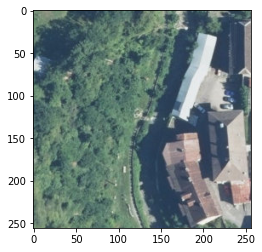

In [28]:
for (image, mask),(image2, mask2) in zip(train_ds, tmp_train):
    plt.imshow(image[0])
    break

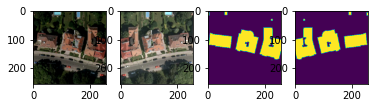

In [29]:
number = 12
_,[ax1,ax2,ax3,ax4] = plt.subplots(1,4)
ax1.imshow(image[number])
ax2.imshow(image2[number])
ax3.imshow(mask[number])
ax4.imshow(mask2[number])
plt.show()

In [30]:
import matplotlib.pyplot as plt

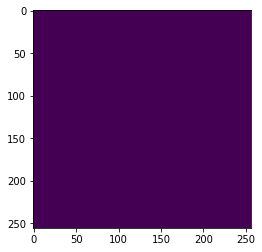

In [31]:
for image, mask in train_ds:
    plt.imshow(mask[0])
    break

In [ ]:
model.fit(train_ds, epochs=1, validation_data=batch_data(val_X, val_y,batch_size, train = False), callbacks=[es], verbose=1)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
28/56 [==============>...............] - ETA: 1:29:11 - loss: 1.5564 - accuracy: 0.6443 - binary_io_u: 0.3915

In [ ]:
#from tensorflow.keras.utils import plot_model

In [ ]:
#plot_model(model,
#    to_file='model.png',
#    show_shapes=True, show_dtype=True,
#    show_layer_names=True,
#    rankdir='TB',
#    expand_nested=True,
#    dpi=96,
#    layer_range=None,
#    show_layer_activations=True)